# SIDIS QED calculation

In [1]:
import sys,os,time
import numpy as np
from numba import jit
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import matplotlib
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{bm} \usepackage{amsmath}"
matplotlib.rc('text',usetex=True)
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.colors import LogNorm
import pylab as py
new_path="/u/home/karki/.local/lib/python3.8/site-packages"
sys.path.append(new_path)



In [ ]:
## load sidis stfs
note: we use numba library. The first execution of the functions will be slow. After that they are compilled and fast

In [2]:
os.environ["stflib"] = "./stflib"
from stflib import FUU,FUTsiv,FUTcol
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import params as par
import alfa
import dglap
from   tools import lprint

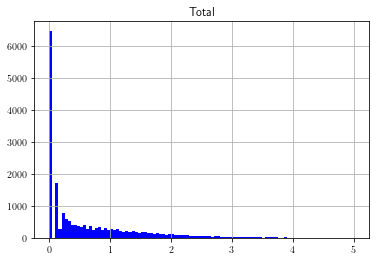

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
os.chdir("/w/halla-scifs17exp/dvcs/disk1/bishnu/DUKE/Cherenkov/maroc_mirazita/solid")
#os.chdir("/w/halla-scifs17exp/dvcs/disk1/bishnu/ForBo/fadc")

#df0=pd.read_csv("./lucite_newSetting_2396_fadc.ml",sep="\t", index_col=0, header=None)
#df0=pd.read_csv("./lucite_bgLED_newSetting_117khz_2464_fadc.ml",sep="\t", index_col=0, header=None)
#df0=pd.read_csv("./lucite_bgLED_newSetting_190khz_2456_fadc.ml",sep="\t", index_col=0, header=None)
#df0=pd.read_csv("./lucite_bgLED_newSetting_320khz_2422_fadc.ml",sep="\t", index_col=0, header=None)

#df1=pd.read_csv("./bgLED_320_run2427_fadc.ml",sep="\t", index_col=0, header=None)
#df2=pd.read_csv("./bgLED_190_run2454_fadc.ml",sep="\t", index_col=0, header=None)
#df3=pd.read_csv("./bgLED_117_run2460_fadc.ml",sep="\t", index_col=0, header=None)

df0=pd.read_csv("./bgLED_run165_fadc_LED.ml",sep="\t", index_col=0, header=None)

#df['Total']=df.loc[:,1:].apply(np.sum,axis=1)
df0['Total'] = df0.apply(np.sum, axis=1)
#df1['Total'] = df1.apply(np.sum, axis=1)
#df2['Total'] = df2.apply(np.sum, axis=1)
#df3['Total'] = df3.apply(np.sum, axis=1)
max_range=5


#df0.hist(column='Total',bins=100,range=(1,max_range), color='b')
df0.hist(column='Total',bins=100,range=(0,max_range), color='b')
plt.show()
#df.head(10)

## load QED evolution scripts

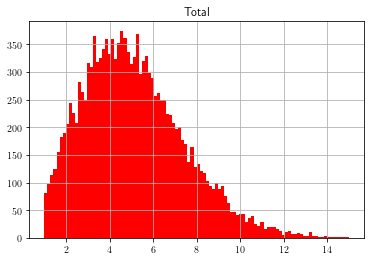

In [70]:
df2.hist(column='Total',bins=100,range=(1,max_range), color='r')
plt.show()

In [3]:
#df3.hist(column='Total',bins=100,range=(1,max_range), color='g')
#plt.show()
import math
Q2=3.54
Q2F=math.floor(Q2)
print(Q2F)

3


## integrand

In [32]:
@jit(nopython=True)

def FUUT_modification(qT_Q,Q,FUUT_nomod,N=20, ctail=0.01):
    R=np.exp(-N * np.power(qT_Q,3))
    qT=Q*qT_QM
    F_Tail=ctail/qT**2
    FUU_mod_in=FUUT_nomod*R + (1 - R)*F_Tail
    return FUU_mod_in

@jit(nopython=True)    
def get_int0(xi,zeta,kinematics,iupol,isiv,icol,rotation=1):
    """ 
     _..._ stands for non RC quantities 
     """
    
    M =par.M ## mass of proton 0.938 GeV
    M_h=par.Mpi ## mass of pion 0.134 GeV
    
     
   # print("Who is this", M," m and h", M_h)
    
    #--retrieve & build non RC quantities
    _s_        =kinematics[0]
    _Q_        =kinematics[1]
    _x_        =kinematics[2]
    _y_        =kinematics[3]
    _z_        =kinematics[4]
    _PhT_      =kinematics[5]
    _cos_phih_ =kinematics[6]
    _cos_phis_ =kinematics[7]
    _sin_phih_ =kinematics[8]
    _sin_phis_ =kinematics[9]
    _ST_       =kinematics[10]

    _l1T2_   = _Q_**2*(-M**2*_x_**2*_y_**2 - _Q_**2*_y_ + _Q_**2)/(_y_**2*(4*M**2*_x_**2 + _Q_**2))
    _l1T_     = np.sqrt(_l1T2_)

    _qdotPh_ = _Q_*(_Q_**3*_z_ - np.sqrt(-(4*M**2*_x_**2 + _Q_**2)*(4*M**2*M_h**2*_x_**2 + 4*M**2*_PhT_**2*_x_**2 - _Q_**4*_z_**2)))/(4*M**2*_x_**2)
    _l1dotPh_= (-4*M**2*_PhT_*_l1T_*_x_**2*_y_*_cos_phih_ + 2*M**2*_x_**2*_y_*_qdotPh_ - \
               _PhT_*_Q_**2*_l1T_*_y_*_cos_phih_ - _Q_**4*_y_*_z_/2 + _Q_**4*_z_ + _Q_**2*_qdotPh_)/(_y_*(4*M**2*_x_**2 + _Q_**2)) 
    _l2dotPh_=_l1dotPh_-_qdotPh_ 

    _qdotS_  = -_Q_*np.sqrt(-(_ST_ - 1)*(_ST_ + 1)*(4*M**2*_x_**2 + _Q_**2))/(2*M*_x_)    
    _l1dotS_ = (-4*M**2*_ST_*_l1T_*_x_**2*_y_*_cos_phis_ + 2*M**2*_x_**2*_y_*_qdotS_\
               - _Q_**2*_ST_*_l1T_*_y_*_cos_phis_ + _Q_**2*_qdotS_)/(_y_*(4*M**2*_x_**2 + _Q_**2))  

    _l2dotS_=_l1dotS_-_qdotS_ 

    _eps_Pl1l2Ph_=-_PhT_*_Q_**2*_l1T_*np.sqrt(4*M**2*_x_**2/_Q_**2 + 1)*_sin_phih_/(2*_x_)
    _eps_Pl1l2S_ =-_ST_ *_Q_**2*_l1T_*np.sqrt(4*M**2*_x_**2/_Q_**2 + 1)*_sin_phis_/(2*_x_)


    #--build RC kinematic quantities
    s        = xi*_s_
    x        = _Q_**2*_x_*xi*_y_/(_Q_**2*(xi*zeta + _y_ - 1))
    y        = (xi*zeta + _y_ - 1)/(xi*zeta)
    z        = _y_*_z_*zeta/(xi*zeta + _y_ - 1)
    Q2       = _Q_**2*xi/zeta
    Q        = np.sqrt(Q2)        
    gam2     = (2*M*x)**2/Q2
    gam      = np.sqrt(gam2)
    
    l1T2     = Q**2*(-M**2*x**2*y**2 - Q**2*y + Q**2)/(y**2*(4*M**2*x**2 + Q**2))
    l1T      = np.sqrt(l1T2)

    l1dotPh  = xi*_l1dotPh_
    l2dotPh  = _l2dotPh_/zeta
    l1dotS   = xi*_l1dotS_
    l2dotS   = _l2dotS_/zeta

    eps_Pl1l2Ph = (xi/zeta)*_eps_Pl1l2Ph_
    eps_Pl1l2S  = (xi/zeta)*_eps_Pl1l2S_

    qdotPh   = l1dotPh-l2dotPh 
    qdotS    = l1dotS-l2dotS 

    PhT2     = (-4*M**2*M_h**2*Q**2*x**2 - 4*M**2*x**2*qdotPh**2 - M_h**2*Q**4 + Q**6*z**2 + 2*Q**4*z*qdotPh)/(Q**2*(4*M**2*x**2 + Q**2))
    PhT      = np.sqrt(np.abs(PhT2))
    if  rotation==0: PhT=_PhT_
       
    ST2      = (4*M**2*Q**2*x**2 - 4*M**2*x**2*qdotS**2 + Q**4)/(Q**2*(4*M**2*x**2 + Q**2))
    ST       = np.sqrt(np.abs(ST2))
    Spar     = 2*M*x*qdotS/(Q**2*np.sqrt(4*M**2*x**2/Q**2 + 1))

    cos_phih = (4*M**2*x**2*y*qdotPh - Q**4*y*z + 2*Q**2*(Q**2*z + qdotPh)- 2*y*(4*M**2*x**2 + Q**2)*l1dotPh)/(2*PhT*l1T*y*(4*M**2*x**2 + Q**2))                    
    cos_phis = (2*M**2*x**2*y*qdotS + Q**2*qdotS-y*(4*M**2*x**2 + Q**2)*l1dotS)/(ST*l1T*y*(4*M**2*x**2 + Q**2))

    sin_phih = -2*x*eps_Pl1l2Ph/(PhT*Q**2*l1T*np.sqrt(4*M**2*x**2/Q**2 + 1))
    sin_phis = -2*x*eps_Pl1l2S /( ST*Q**2*l1T*np.sqrt(4*M**2*x**2/Q**2 + 1))

    if iupol==1:
        FUU_ = FUU.get_FUU(x,z,Q2,PhT,'p','pi+') 
    else:        FUU_ = 0
        
    qT_Q=PhT/z/Q   
    #FUU_ = FUUT_modification(qT_Q,Q,FUU_)
    if isiv==1: FUTsiv_ = FUTsiv.get_FUT(x,z,Q2,PhT,'p','pi+')
    else:       FUTsiv_ = 0

    if icol==1: FUTcol_ = FUTcol.get_FUT(x,z,Q2,PhT,'p','pi+')    
    else:       FUTcol_ = 0
      
    
    #print("{0:.2f}".format(Q2))
    #f = open("Unp_Q{}_rs140_const_alpha_QED.txt".format(Q), "w")
    
    print("  ",xi," ",zeta, "  ",x,"  ", Q2,"  ",PhT,"  ",z, " ", FUU_)
    #print(zeta,"\t", x,"\t", Q2,"\t",PhT,"\t"," \t ",z)
   
    
    
    eps  = (1-y-0.25*gam2*y**2)/(1-y+0.5*y**2+0.25*gam2*y**2)
    eps_B=(1-y)/(1-y+0.5*y**2)
    jac  = x/_x_/xi/zeta 
   # if running_alpha_QED==1:
    #norm = alfa.get_alfa(Q2)**2/(x*y*Q2) * y**2/2/(1-eps) * (1+gam2/2/x)
    #else: 
    norm =par.alfa0**2/(x*y*Q2) * y**2/2/(1-eps) * (1+gam2/2/x)
    #print(eps,"\t",eps_B)    
    phase_sivers  = sin_phih*cos_phis - sin_phis*cos_phih
    phase_collins = sin_phih*cos_phis + sin_phis*cos_phih


    out=jac*norm*(FUU_ + ST*phase_sivers*FUTsiv_ + ST*eps*phase_collins*FUTcol_)
    #print("I am integrand integ_0",ST, eps, phase_collins, out)
    return out


@jit(nopython=True)
def get_xi_min(zeta,kinematics):
    y,x,z=kinematics[3],kinematics[2],kinematics[4]
    return max([(1-y+z*zeta*y)/zeta,(1-y)/(zeta-x*y)])

@jit(nopython=True)
def get_zeta_min(kinematics):
    y,x,z=kinematics[3],kinematics[2],kinematics[4]
    return max([(1-y)/(1-z*y),1-y+x*y])   
## integrand with 3rd term with LDF (xi)
@jit(nopython=True)
def get_box(xi,zeta,kinematics,F,jac_xi,mu2,iupol,isiv,icol,rotation=1):
    xi_min =get_xi_min(zeta,kinematics)
    LDF    =dglap.get_LDF(xi,F,mod=False)
    LDF2   =dglap.get_LDF(xi_min,F,mod=True)
    int0_xi_zeta =get_int0(xi,zeta,kinematics,iupol,isiv,icol,rotation)
    int0_one_zeta=get_int0(1,zeta,kinematics,iupol,isiv,icol,rotation)
    return LDF*(int0_xi_zeta-int0_one_zeta)*jac_xi +int0_one_zeta*xi_min*LDF2
## integrand zeta, xi and 3rd term 
@jit(nopython=True)
def get_integrand0(X,kinematics,F,D,iupol,isiv,icol,rotation=1):
    mu2=kinematics[1]**2 #Q2
    zeta_min=get_zeta_min(kinematics)
    jac_zeta=1-zeta_min
    zeta=zeta_min + X[0]*jac_zeta

    xi_min=get_xi_min(zeta,kinematics)
    jac_xi=1-xi_min
    xi=xi_min + X[1]*jac_xi
    

    LFF =dglap.get_LFF(zeta,D,mod=False)
    LFF2=dglap.get_LFF(zeta_min,D,mod=True)
        
    box_xi_zeta=get_box(xi,zeta,kinematics,F,jac_xi,mu2,iupol,isiv,icol,rotation)
    box_xi_one =get_box(xi,1,kinematics,F,jac_xi,mu2,iupol,isiv,icol,rotation)

    theta=1
    if xi<get_xi_min(1,kinematics): theta=0
    integrand=LFF*(box_xi_zeta-box_xi_one*theta)*jac_zeta + box_xi_one*theta*zeta_min*LFF2
    #print(box_xi_zeta,box_xi_one,integrand)
    
    return integrand
## term with
@jit(nopython=True)
def get_integrand1(X,kinematics,F,D,iphih,iphis,iupol,isiv,icol,qed_order=1,rotation=1,iphase=1):
    phis=-np.pi + 2*np.pi*X[2]
    phih=-np.pi + 2*np.pi*X[3]
    kinematics[6] = np.cos(phih)
    kinematics[7] = np.cos(phis)
    kinematics[8] = np.sin(phih)
    kinematics[9] = np.sin(phis)
    
    jac   = (2*np.pi)**2
    if iphase==1:
        phase = np.sin(iphih*phih+iphis*phis)*jac
    else:
         phase=1
    if qed_order==0:
        int0=get_int0(1,1,kinematics,iupol,isiv,icol,rotation)
        out=int0*phase
        
    elif qed_order==1:
        integrand0=get_integrand0(X,kinematics,F,D,iupol,isiv,icol,rotation)
        out=integrand0*phase

    if np.isnan(out):
        out=0
        print('get_integrand1 is giving NAN')
    #print(phase,"   befor phase after out " "   phase    ===", iphase)
    return out
    


In [31]:
def test(rotation): 
    
    rs  = 140
    #x   = 0.01 # xb=0.32
    z   = 0.5 #0.55
    Q   =10
    y=0.4
    qT_Q= 0.5 #qT/Q 
    ### pt_square = 0.01 to 0.19 
    
    #sqrt(s) = 2(sqrt E_e x E_p)
  
    # FIXED ANGLE FOR UNPOLARIZED 
    phih = 0
    phis = 0
    iphih = 0  
    iphis = 0   
    
    iupol = 1 
    isiv  = 0 
    icol  = 0
    qed_order  = 1
    dglap_order= 1
    
    if iupol==1:
        iphase = 0
    else:
        iphase = 1

    nbiter,nburn = 1,1000
    neiter,neval = 1,10000
    ftol=1e-2


    
    if qed_order==0:
        RC_status="noQED"
    else: RC_status="QED"

   
    #f = open("Unp_Q{}_rs140_const_alpha_QED_noROT.txt".format(Q), "w")
    while(qT_Q<0.52):
        x   =Q**2/rs**2/y
        qT  =qT_Q*Q
        PhT =z*qT
        ST  =1
        kinematics=np.zeros(11)
        kinematics[0] = rs**2
        kinematics[1] = Q
        kinematics[2] = x
        kinematics[3] = y
        kinematics[4] = z
        kinematics[5] = PhT
        
        kinematics[6] = np.cos(phih)
        kinematics[7] = np.cos(phis)
        kinematics[8] = np.sin(phih)
        kinematics[9] = np.sin(phis)
        
        kinematics[10]= ST
        f_zeta=0.76
        while f_zeta <1.01:
            f_xi=1
            #f_zeta=1
            LO=get_int0(f_xi,f_zeta,kinematics,iupol,isiv,icol,rotation)
            f_zeta+=0.01
        qT_Q+=0.5;
test(1)

   1   0.76    0.03188775510204078    131.57894736842104    8.30936444755732    0.9499999999999993   -1.2826305888347167e-54
   1   0.77    0.030012004801920775    129.87012987012986    7.739827073514029    0.905882352941177   1.2521433709278398e-50
   1   0.78    0.028344671201814033    128.2051282051282    7.233569845492679    0.866666666666666   4.405416061609234e-47
   1   0.79    0.02685284640171859    126.58227848101265    6.780601504473126    0.8315789473684214   6.791820537613478e-44
   1   0.8    0.025510204081632626    125.0    6.372928964344257    0.7999999999999995   5.555032416372078e-41
   1   0.81    0.024295432458697763    123.45679012345678    6.004081577304113    0.7714285714285717   2.6790667141126534e-38
   1   0.8200000000000001    0.023191094619666022    121.95121951219511    5.6687651388940425    0.7454545454545449   7.989535755649349e-36
   1   0.8300000000000001    0.022182786157941434    120.48192771084337    5.3626061486917935    0.7217391304347828   1.556668

Pht insde main function  1.5
36.596521615982056


In [22]:
def test():
    rs  =3.2
    x   =0.32
    z   =0.55
    Q2 =2.31
    Q   =np.sqrt(Q2)
    maxval=1
    qT_Q=0.01 ## is qT/Q
    y   =Q**2/rs**2/x
    PhT_temp=0
    while qT_Q<maxval:
        qT  =qT_Q*Q ## qT
        PhT =z*qT
        print("PhT  ",PhT)
        if PhT>PhT_temp:
            PhT_max=PhT
            PhT_temp=PhT_max
        qT_Q+=0.1
    print("Pht insde main function ", PhT_max)
test()

PhT   0.008359276284463866
PhT   0.09195203912910252
PhT   0.17554480197374117
PhT   0.25913756481837985
PhT   0.34273032766301853
PhT   0.42632309050765715
PhT   0.5099158533522957
PhT   0.5935086161969344
PhT   0.677101379041573
PhT   0.7606941418862116
Pht insde main function  0.7606941418862116


## Reading the file in dataframe and writing and plotting columns in same plot 

In [ ]:
def structure(xB,z,Q2,pht):
    return FUU.get_FUU(xB,z,Q2,pht,'p','pi+') 
import matplotlib.pyplot as plt
import pandas as pd
def process_Duane_File():
    os.chdir("/w/halla-scifs17exp/dvcs/disk1/bishnu/ForDuane")
    ############### FIRST PROCESS THE DUANE FILE ############
    header_list=["zeta", "xB", "Q2", "pht", "z"]
    dfD=pd.read_csv("./Shift_EIC2_xi1.txt",sep="\t",  header=None, names=header_list)
    dfD['FUU']=dfD.apply(lambda x: structure(x['xB'],x['z'],x['Q2'],x['pht']),axis=1)
    index = dfD.index
    number_of_rows = len(index)
    print(number_of_rows)
    new_col = np.full((number_of_rows, 1), 1)
    dfD.insert(loc=0, column='xi', value=new_col)
    dfD.to_csv("Shift_kinematic_Duane.txt", sep='\t', index=False,  float_format='%.3e')
############################

def compare():
    os.chdir("/w/halla-scifs17exp/dvcs/disk1/bishnu/ForDuane")
    header_list=["xi ","zeta", "xB", "Q2", "pht", "z", "FUU"]
    dfD=pd.read_csv("./Shift_kinematic_Duane.txt",sep="\t")
    #dfB=pd.read_csv("./shift_RC_bishnu.txt",sep='\t', header=None)
    dfB=pd.read_csv(r'shift_RC_bishnu.txt', sep='\s+', header=None, names=header_list)
    pd.set_option('display.float_format','{:.3e}'.format)
   
   
    #dfD.scatter(dfD['zeta'], dfD['FUU'])
    ax=dfD.plot(x='zeta', y='FUU',style='o')
    dfB.plot(x='zeta', y='FUU',style='*', ax=ax)
    #dfD.head(5)
    #print(dfB)
    #print(dfB)
#process_Duane_File()
compare()

## OK next lets integrate to get cross section

In [80]:
print(dfD)
   


    xi      zeta        xB        Q2       pht         z        FUU
0    1 7.600e-01 3.189e-02 1.316e+02 8.309e+00 9.500e-01 -1.283e-54
1    1 7.700e-01 3.001e-02 1.299e+02 7.740e+00 9.059e-01  1.252e-50
2    1 7.800e-01 2.834e-02 1.282e+02 7.234e+00 8.667e-01  4.406e-47
3    1 7.900e-01 2.685e-02 1.266e+02 6.781e+00 8.316e-01  6.792e-44
4    1 8.000e-01 2.551e-02 1.250e+02 6.373e+00 8.000e-01  5.555e-41
5    1 8.100e-01 2.430e-02 1.235e+02 6.004e+00 7.714e-01  2.679e-38
6    1 8.200e-01 2.319e-02 1.220e+02 5.669e+00 7.455e-01  7.989e-36
7    1 8.300e-01 2.218e-02 1.205e+02 5.363e+00 7.217e-01  1.556e-33
8    1 8.400e-01 2.126e-02 1.190e+02 5.082e+00 7.000e-01  2.052e-31
9    1 8.500e-01 2.041e-02 1.176e+02 4.824e+00 6.800e-01  1.905e-29
10   1 8.600e-01 1.962e-02 1.163e+02 4.585e+00 6.615e-01  1.276e-27
11   1 8.700e-01 1.890e-02 1.149e+02 4.365e+00 6.444e-01  6.351e-26
12   1 8.800e-01 1.822e-02 1.136e+02 4.160e+00 6.286e-01  2.408e-24
13   1 8.900e-01 1.759e-02 1.124e+02 3.969e+00 6

## At fixed angles phi_h


In [35]:

print(FUU.get_FUU(0.031888,0.95000, 131.57, 8.309,'p','pi+'))

-1.2951910275524616e-54


#### Calulation for RC factor at fixed phi_h (Geve Sqrt(s), y, z, Q, qT_Q)

#  For JLab kinematics ( Electron beam energy 5.479 and E'=1.702 GeV

In [8]:
import numpy as np
I=np.identity(3)
I

      

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

### This is for the asymmetry (Collins and Sievers)


### Below this are the test I am doing to understand the code

In [1]:
for i in range(6):
    print(i,sep=' ',end=' ',flush=True)
mean,std=np.empty(2)
print(mean," ",std)
for i, j in ragne(0,5,1) range(5,10,1)

SyntaxError: invalid syntax (<ipython-input-1-944cdf07cf04>, line 5)

### 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#with open('/u/home/karki/QEDSIDIS-main/Q10_UnPolarized.txt') as f:
#    contents = f.read()
#    print(contents)
#filename1="/u/home/karki/QEDSIDIS-main/Q10_UnPolarized.txt"
df =      pd.read_csv('/u/home/karki/QEDSIDIS-main/Q10_UnPolarized.txt', delimiter=" ",header=None)
df_noRC = pd.read_csv', delimiter=" ",header=None)
df.columns = ["qT_Q", "sigma_1", "E_sigma"]
df_noRC.columns=["qT_Q","sigma_0","Esingma0"]
print(df_noRC)
fig, ax = plt.subplots()
#ax.plot(df['qT_Q'],df['sigma_0'].div(df['sigma_1']), label='points')
#ax.plot(df['qT_Q'],df['sigma_0'], label='points')
#ax.plot(X="qT_Q",Y="sigma_0")

#tick_spacing = 1
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#df.columns = ["x", "y1", "y2"]
#qT_Q,sigma_1,E_sigma_1=np.genfromtxt(filename1, delimiter=" " , dtype= None  )
#np.loadtxt("./Q10_UnPolarized.txt",  dtype={'names': ('qT_Q', 'sigma_1', 'E_sigma'), 'formats': ('f4', 'f4', 'f4') },  delimiter=' ', skiprows=0)
'''
plt.plot(qT_Q,sigma_1, label='Loaded from file!')

plt.xlabel('qT_Q')
plt.ylabel('sigma_1')
plt.title('sigma')
plt.legend()
'''

rs  = 140
x   = 0.01
z   = 0.5
Q   = 10

qT_Q= 0.05 #qT/Q
#y   =Q**2/rs**2/x
y=0.4
xB=Q**2/rs**2/y
print(xB)

In [4]:
import numpy as np
def charge_conj(p):
    out=np.zeros(len(p))
    cnt=0
    for i in [0,2,1,4,3,6,5,8,7,10,9]:
        out[cnt]=p[i]
        cnt+=1
    return out
#charge_conj(5)
had='pi-'
if had.endswith('+'):
    print('You are right sir')
else :
    print('I am from else')

I am from else


In [21]:
import matplotlib.pyplot as plt
import numpy as np
iphih = 1
iphis =-1
jac   = (2*np.pi)**2
X=np.random.uniform(0,1,(4,10000))
for x in X:
    phis=-np.pi + 2*np.pi*X[2]
    phih=-np.pi + 2*np.pi*X[3]
    phase = np.sin(iphih*phih+iphis*phis)*jac
    phase1=iphih*phih
    phase2=iphis*phis

#kinematics[6] = np.cos(phih)
#kinematics[7] = np.cos(phis)
#kinematics[8] = np.sin(phih)
#kinematics[9] = np.sin(phis)
#jac   = (2*np.pi)**2
x_bins = np.linspace(-10,10,100)
y_bins=x_bins
#print(iphih*phih, "   ", iphis*phis, " ",-np.pi)
plt.hist(phase1, bins, alpha=0.5, label='phih')
plt.hist(phase2, bins, alpha=0.5, label='phis')
plt.hist2d(phase1,phase2, bins=[x_bins,y_bins],cmap = plt.cm.nipy_spectral)
#plt.plot(phase1,phase2, marker='*',markersize=10, linestyle='None')
#plt.xlabel('phih')
plt.colorbar()
#plt.show()

NameError: name 'bins' is not defined

In [ ]:
import alfa
import matplotlib.pyplot as plt
import numpy as np
Q2=0.1
norm0=[]
norm1=[]
Q2_plot=[]
val=alfa.get_alfa(Q2)**2
print((val-par.alfa0**2)*100/par.alfa0**2)

while Q2<6:
    
    norm0.append(par.alfa0)
    norm1.append(100*alfa.get_alfa(Q2))#/par.alfa0)
    Q2_plot.append(Q2)
    Q2+=0.5
    
fig, ax = plt.subplots()
#plt.scatter(Q2_plot, norm0, c='b', marker='x', label='1')
ax.plot(Q2_plot, norm1, c='r', marker='o', label='running ' )

#ax.plot( Q2_plot, norm1,'r--',label=' norm1')
ax.yaxis.label.set_size(20)

ax.tick_params(axis="y", labelsize=15)
ax.tick_params(axis="x", labelsize=15)
#ax.set_xscale('log')
#ax.set_yticks(norm1)
#ax.set_yticklabels(norm1,fontsize=18)
'''
ax.set_ylim(0.00001,1)
#ax.set_yticklabels('{0:.3f}'.format(FUU_nomod),fontsize=15)
 
ax.set_yticklabels(norm1,fontsize=18)
'''
plt.show()
print(" check this   ",1/alfa.get_alfa(12.25) - 1/alfa.get_alfa(3434))



In [ ]:
fig,axe=plt.subplots()
plt.hist(np.random.randn(100))
plt.savefig("kera.pdf")

In [13]:
import numpy as np
iupol = 1 
isiv  = 0 
icol  = 0
qed_order  = 0
dglap_order= 1
rotation   = 0
z=[0.55, 0.375, 0.375, 0.5, 0.5, 0.5]
Q=[1.52, 2.83, 3.87, 3,5,10]
PhT=1.5
for i, j in zip(z,Q):
    #print(z,"    ",Q)
    qT=PhT/np.asarray(i)
    qT_Q  =qT/np.asarray(j)
    print(qT_Q)


1.7942583732057416
1.4134275618374559
1.0335917312661498
1.0
0.6
0.3


In [42]:
rate=320
window=36 
rate=rate*1e3
window =window*1e-9
pixels=960
Npe=rate*window*pixels # count s-1* s
print(Npe," counts ")


11.0592  counts 


In [19]:
import numpy as np
#print(np.sqrt(1.5))
#print(1.5**2)
qT_Q=0.6
Q=5
z=0.5
qT  =qT_Q*Q
PhT =z*qT
print(PhT)

1.5


In [21]:
0.02*3.87*0.375

0.029025000000000002